Generating synthetic rosette data for paper.

In [2]:
# import packages
import numpy as np
import cadquery as cq
from scipy.stats import qmc
import math
import itertools
import matplotlib.pyplot as plt
import os
import json
import copy
import random

# Load spherical code

In [3]:
s_code_dir = '/glade/u/home/joko/spherical-code/data/text-files'
n_min, n_max = 4, 11
n_vals = list(range(n_min, n_max))
s_code = {} # dictionary that holds coordinates for spherical code 
for i in n_vals:
    filename = f'pack.3.{i}.txt'
    filepath = os.path.join(s_code_dir, filename)
    with open(filepath, 'r') as file:
        values = [float(line.strip()) for line in file]
    s_code[i] = values

In [6]:
type(list(s_code.keys())[0])

int

In [49]:
# Define the path to save the JSON file
save_dir = '/Users/josephko/research/spherical-code/data'
json_filepath = os.path.join(save_dir, 's_code.json')

# Save the s_code dictionary as a JSON file
with open(json_filepath, 'w') as json_file:
    json.dump(s_code, json_file)

In [6]:
# Read the JSON file as a dictionary
# NOTE: when reading in from JSON, the key is read as a string
json_filepath = '/glade/u/home/joko/spherical-code/data/s_code.json'
with open(json_filepath, 'r') as json_file:
    s_code_dict = json.load(json_file)

# Print the dictionary to verify
print(s_code_dict)

{'4': [-0.577350269072, 0.577350269072, -0.577350269072, 0.577350269072, 0.577350269072, 0.577350269072, -0.577350269072, -0.577350269072, 0.577350269072, 0.577350269072, -0.577350269072, -0.577350269072], '5': [-0.14782559370880183, 0.8557801392177641, 0.495770054728061, 0.9298520676823501, -0.3330452755499896, -0.15638406779685032, -0.7820264758448114, -0.5227348665222011, -0.33938599028209954, -0.036123069457864206, -0.5056147808319168, 0.8620027942282061, 0.036123069583033664, 0.505614780103487, -0.8620027946502272], '6': [0.21254825592, -0.977150570601, 0.0, -0.977150570601, -0.21254825592, 0.0, -0.21254825592, 0.977150570601, 0.0, 0.977150570601, 0.21254825592, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0], '7': [-0.9476914051796328, -0.20521795145581753, 0.24447206987492645, 0.8503710682661693, 0.48308483448290185, 0.20856195470047173, -0.4995609516538522, 0.3276811928816585, -0.8019126457503652, -0.3344875986220292, 0.8899589445240679, 0.30998568262046483, 0.024203814844953528, -0.992443

# Generate parameters list

In [7]:
'''
Parameters: a, c/a, f_r0, f_hp, f_h0
Generate N samples using LHS
'''
N = 1000 # of LHS samples
# define parameter ranges 
a_min, a_max = 10, 50 # microns
c_over_a_min, c_over_a_max = 1.25, 10 # unitless
f_r0_min, f_r0_max = 0.8, 1.2
f_hp_min, f_hp_max = 0.8, 1.2
f_h0_min, f_h0_max = 0.8, 1.2

# generate LHS
sampler = qmc.LatinHypercube(d = 5, optimization='random-cd')
samples = sampler.random(n=N)

# metric for quality of the samples
print(qmc.discrepancy(samples))

# scale samples to bounds
l_bounds = [a_min, c_over_a_min, f_r0_min, f_hp_min, f_h0_min]
u_bounds = [a_max, c_over_a_max, f_r0_max, f_hp_max, f_h0_max]
param_list = qmc.scale(samples, l_bounds, u_bounds)
param_list[:5]

6.413657109072268e-05


array([[12.12720579,  2.18518529,  1.16651005,  1.14756084,  0.9477042 ],
       [47.9982257 ,  7.2669981 ,  1.08444377,  0.80209918,  1.01139255],
       [42.16986649,  3.49702783,  0.9290787 ,  1.12625609,  0.97209866],
       [39.45926633,  6.63599927,  1.19555039,  1.10881897,  1.19359301],
       [11.56216263,  1.65135086,  1.15321396,  1.00853823,  1.01211716]])

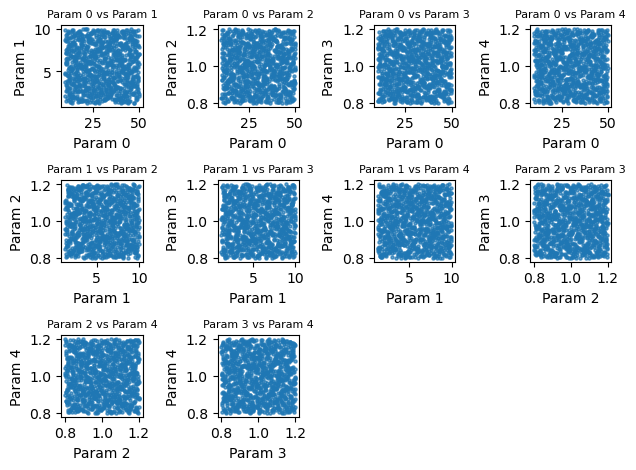

In [8]:
# plot 2-d cross sections of parameter space to visually inspect

# Calculate the ideal number of rows and columns
total_subplots = len(list(itertools.combinations(range(param_list.shape[1]), 2)))
ncols = math.ceil(math.sqrt(total_subplots))
nrows = math.ceil(total_subplots / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

# Plot each unique combination of columns
for i, (x_idx, y_idx) in enumerate(itertools.combinations(range(param_list.shape[1]), 2)):
    ax = axes[i]
    ax.scatter(param_list[:, x_idx], param_list[:, y_idx], s=5, alpha=0.7)
    ax.set_xlabel(f'Param {x_idx}')
    ax.set_ylabel(f'Param {y_idx}')
    ax.set_title(f'Param {x_idx} vs Param {y_idx}', fontsize=8)
    ax.set_box_aspect(1)
    # ax.set_aspect('equal', adjustable='datalim')  # Set aspect ratio to be equal

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.subplots_adjust(wspace=0.5, hspace=0.0)
plt.show()

By this point, N combinations of (a, c/a, f_r0, f_hp, f_h0) have been generated and saved in 'param_list'.

# Generate unperturbed rosettes

Generate dataset of rosettes with no perturbations to arms.

In [9]:
param_list

array([[12.12720579,  2.18518529,  1.16651005,  1.14756084,  0.9477042 ],
       [47.9982257 ,  7.2669981 ,  1.08444377,  0.80209918,  1.01139255],
       [42.16986649,  3.49702783,  0.9290787 ,  1.12625609,  0.97209866],
       ...,
       [43.94645763,  9.58598701,  0.9927907 ,  1.11068177,  0.97412726],
       [45.08235882,  7.50700937,  0.93438122,  0.99846792,  1.12462786],
       [11.43237365,  3.74433629,  1.15482174,  0.86725113,  1.10359173]],
      shape=(1000, 5))

In [10]:
param_list[0]

array([12.12720579,  2.18518529,  1.16651005,  1.14756084,  0.9477042 ])

paramlist: a_min, c_over_a_min, f_r0_min, f_hp_min, f_h0_min

In [27]:
# create final params list in the form (a, c, f_r0, f_hp, f_h0)
geo_params = []
for i in range(len(param_list)):
    record = copy.deepcopy(param_list[i])
    record[1] = record[0] * record[1]
    record = record.tolist()
    geo_params.append(record)

In [11]:
# Example 2D list
matrix = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

# Number of repetitions
N = 3

# Initialize an empty list to store the results
result = []

# Loop over the range N to repeat the list N times
for i in range(N):
    # Append the index i to each row of the matrix
    modified_matrix = [row + [i] for row in matrix]  # Appending the index to each row
    
    # Append the modified matrix to the result list
    result.append(modified_matrix)

# Print the result
for i, matrix in enumerate(result):
    print(f"Matrix after iteration {i}:")
    for row in matrix:
        print(row)
    print()  # Add an empty line between matrices


Matrix after iteration 0:
[1, 2, 3, 0]
[4, 5, 6, 0]
[7, 8, 9, 0]

Matrix after iteration 1:
[1, 2, 3, 1]
[4, 5, 6, 1]
[7, 8, 9, 1]

Matrix after iteration 2:
[1, 2, 3, 2]
[4, 5, 6, 2]
[7, 8, 9, 2]



In [20]:
matrix

[[1, 2, 3, 2], [4, 5, 6, 2], [7, 8, 9, 2]]

In [40]:
# add n_arms as parameters & save as text file
geo_params_final = []
for i in n_vals:
    temp = [row + [i] for row in geo_params]
    geo_params_final.extend(temp)
# convert to np array
params_np = np.array(geo_params_final)
# save as csv
savepath = '/glade/u/home/joko/ice3d/output/params_test.csv'
np.savetxt(savepath, params_np, delimiter=',', fmt='%.2f')

In [43]:
# read the csv file back 
params_np = np.loadtxt(savepath, delimiter=',')
params_np.shape

(7000, 6)

In [117]:
test_params = geo_params[:10]

In [118]:
test_params[1]

array([ 40.14986855, 261.11732461,   1.03930864,   0.81948583,
         0.91953936])

In [110]:
def extract_xyz(s_code):
    '''
    Convert list in format [x1, y1, z1, ..., xn, yn, zn] to separate x, y, z arrays
    '''
    x = []
    y = []
    z = []
    for i in range(0, len(s_code), 3):
        x.append(s_code[i])
        y.append(s_code[i+1])
        z.append(s_code[i+2])
    return x, y, z

x, y, z = extract_xyz(s_code_dict['4'])
print(f'x: {x}')
print(f'y: {y}')
print(f'z: {z}')


x: [-0.577350269072, 0.577350269072, -0.577350269072, 0.577350269072]
y: [0.577350269072, 0.577350269072, -0.577350269072, -0.577350269072]
z: [-0.577350269072, 0.577350269072, 0.577350269072, -0.577350269072]


In [ ]:
# For each value of n_arm, generate N rosettes using param_list
def create_bullet(a, c, hp, workplane):
    # create pyramid
    n_pyr = 6
    ri = a*np.cos(np.radians(30)) # distance between center and edge of hexagon
    theta = 90 - np.degrees(np.arctan(hp/ri))
    pyramid = workplane.polygon(n_pyr, 2*a).extrude(-hp, taper=theta)
    # create cylinder 
    n_cyl = 6
    cylinder = workplane.polygon(n_cyl, 2*a).extrude(2*c)
    # create bullet (union)
    bullet = cylinder.union(pyramid)
    return bullet

def calc_r0(f_r0, a, n_arms):
    '''
    linearly interpolate between perscribed limits for r0
    '''
    ymin, ymax = 0.5*a, 1*a
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    r0 = slope*(n_arms) + intercept
    r0 = f_r0 * r0 # multiply by perturbation factor
    return r0 

def calc_hp(f_hp, r0, n_arms):
    '''
    linearly interpolate: hp increases with n_arms
    '''
    ymin, ymax = 1*r0, 1.5*r0
    xmin, xmax = 4, 12
    slope = (ymax-ymin)/(xmax-xmin)
    intercept = ymin - (slope*xmin)
    hp = slope*(n_arms) + intercept
    hp = f_hp*hp # multiply by perturbation factot
    return hp

def calc_h0(f_h0, r0):
    '''
    h0 calculate as a perscribed fraction of r0
    '''
    h0 = r0/2
    h0 = f_h0*h0 # multiply by perturbation factor
    return h0

def extract_xyz(s_code):
    '''
    Convert list in format [x1, y1, z1, ..., xn, yn, zn] to separate x, y, z arrays
    '''
    x = []
    y = []
    z = []
    for i in range(0, len(s_code), 3):
        x.append(s_code[i])
        y.append(s_code[i+1])
        z.append(s_code[i+2])
    return x, y, z

def create_ros(params, n_arms, s_code):
    print(f'test print 1: {params}')
    # unpack parameters
    a, c, f_r0, f_hp, f_h0 = params[0], params[1], params[2], params[3], params[4]
    r0 = calc_r0(f_r0, a, n_arms)
    hp = calc_hp(f_hp, r0, n_arms)
    h0 = calc_h0(f_h0, r0)
    print('test print 2: creating sphere')
    # create sphere
    sphere = cq.Workplane().sphere(r0)
    # create outer shell to "place" bullets on
    # based on spherical code from Sloane et al. 
    r_outer = r0 + hp - h0
    # convert s_code list to outer_coords
    x, y, z = extract_xyz(s_code)
    outer_coords = r_outer*(np.column_stack((x, y, z)))
    print('test print 3: creating bullets')
    # create and collect bullets in list
    bullets = []
    for i in range(len(outer_coords)):
        normal_vector = tuple(outer_coords[i])
        plane = cq.Plane(origin=normal_vector, normal=normal_vector)
        workplane = cq.Workplane(plane)
        bullet = create_bullet(a, c, hp, workplane)
        bullets.append(bullet)
    # boolean union to create rosette
    ros = sphere.union(bullets[0])
    for i in range(1, n_arms):
        ros = ros.union(bullets[i])
    return ros

# Main
random.seed(42)  # for reproducibility
n_samples = 5
params = random.sample(geo_params, n_samples)
save_dir = '/Users/josephko/research/ice3d/output/rosette_cq_test'
for i in n_vals:
    test_count = 1
    for p in params: 
        print(f'creating ros #{test_count} for n_arms = {i}')
        s_code = s_code_dict[str(i)]
        ros = create_ros(p, i, s_code)
        filename = f'ros_n{i}_{test_count}.stl'
        save_subdir = save_dir + f'/{i}'
        if not os.path.exists(save_subdir):
            os.makedirs(save_subdir)
        filepath = os.path.join(save_subdir, filename)
        cq.exporters.export(ros, filepath)
        test_count+=1

creating ros #1 for n_arms = 4
test print 1: [ 18.25832147 157.49123648   0.88288557   0.92698134   1.06369897]
test print 2: creating sphere
test print 3: creating bullets
creating ros #2 for n_arms = 4
test print 1: [ 23.20270102 136.41938095   1.05690834   1.10788131   1.17765785]
test print 2: creating sphere
test print 3: creating bullets
creating ros #3 for n_arms = 4
test print 1: [ 43.96701679 305.09254206   1.00041141   0.97459235   1.05515072]
test print 2: creating sphere
test print 3: creating bullets
creating ros #4 for n_arms = 4
test print 1: [ 32.12453153 259.96760816   0.98980319   0.84154503   0.87987383]
test print 2: creating sphere
test print 3: creating bullets
creating ros #5 for n_arms = 4
test print 1: [ 27.2917158  253.23727213   1.00850474   0.94428678   1.13297097]
test print 2: creating sphere
test print 3: creating bullets
creating ros #1 for n_arms = 5
test print 1: [ 18.25832147 157.49123648   0.88288557   0.92698134   1.06369897]
test print 2: creating 

In [115]:
len(geo_params)

5

In [ ]:
ymin = 0.5
ymax = 1
xmin = 4
xmax = 12 
slope = (ymax-ymin)/(xmax-xmin)
print(slope)
intercept = 0.5 - (slope*4)
print(intercept)
n_arms = 4
r0 = slope*(n_arms) + intercept
r0 